In [1]:
# Cell 1: Imports and setup
import os
import math
from vllm import LLM, SamplingParams

# (Optional) adjust your model path here
MODEL_PATH = "/home/ubuntu/fast_llm_inference/models/llama-3.1-8B-Instruct-4bit"

# Cell 2: Load model and define prompts
model = LLM(
    model=MODEL_PATH,
    trust_remote_code=True,
    gpu_memory_utilization=0.9,
    max_model_len=4096,
)

prompts = [
    "The quick brown fox jumps over the lazy dog.",
    "What is the purpose of life?"
]

INFO 05-28 15:18:51 [__init__.py:239] Automatically detected platform cuda.


2025-05-28 15:18:51.873981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748445531.898733  176014 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748445531.906032  176014 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748445531.922127  176014 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748445531.922144  176014 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748445531.922146  176014 computation_placer.cc:177] computation placer alr

INFO 05-28 15:19:13 [config.py:717] This model supports multiple tasks: {'reward', 'generate', 'classify', 'score', 'embed'}. Defaulting to 'generate'.
WARNING 05-28 15:19:15 [config.py:830] bitsandbytes quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 05-28 15:19:15 [config.py:2003] Chunked prefill is enabled with max_num_batched_tokens=8192.
INFO 05-28 15:19:16 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='/home/ubuntu/fast_llm_inference/models/llama-3.1-8B-Instruct-4bit', speculative_config=None, tokenizer='/home/ubuntu/fast_llm_inference/models/llama-3.1-8B-Instruct-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.BITSANDBYTES, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=bitsa

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 05-28 15:19:47 [gpu_model_runner.py:1347] Model loading took 5.3132 GiB and 27.324152 seconds
INFO 05-28 15:20:02 [backends.py:420] Using cache directory: /home/ubuntu/.cache/vllm/torch_compile_cache/0f63e24e8b/rank_0_0 for vLLM's torch.compile
INFO 05-28 15:20:02 [backends.py:430] Dynamo bytecode transform time: 14.88 s
INFO 05-28 15:20:11 [backends.py:118] Directly load the compiled graph(s) for shape None from the cache, took 6.773 s
INFO 05-28 15:20:14 [monitor.py:33] torch.compile takes 14.88 s in total
INFO 05-28 15:20:17 [kv_cache_utils.py:634] GPU KV cache size: 106,880 tokens
INFO 05-28 15:20:17 [kv_cache_utils.py:637] Maximum concurrency for 4,096 tokens per request: 26.09x
INFO 05-28 15:21:20 [gpu_model_runner.py:1686] Graph capturing finished in 64 secs, took 1.54 GiB
INFO 05-28 15:21:21 [core.py:159] init engine (profile, create kv cache, warmup model) took 93.87 seconds
INFO 05-28 15:21:21 [core_client.py:439] Core engine process 0 ready.


In [ ]:
# Cell 3: Configure SamplingParams for logprobs & perplexity
params = SamplingParams(
    temperature=0.1,
    max_tokens=32,
    logprobs=1,
    prompt_logprobs=1
)

# Cell 4: Run generation and display results in a table plus sequence PPL
outputs = model.generate(prompts, params)

for i, gen_out in enumerate(outputs):
    sample    = gen_out.outputs[0]
    text      = sample.text.lstrip()
    lp_list   = sample.logprobs            # list of dicts
    token_ids = sample.token_ids

    # 1) Extract the chosen-token strings & logprobs
    tokens, logps = [], []
    for entry in lp_list:
        # each entry is {token_id: Logprob(...), ...}
        for tid, lp_obj in entry.items():
            if lp_obj.rank == 1:
                tokens.append(lp_obj.decoded_token)
                logps.append(lp_obj.logprob)
                break

    # 2) Compute per-token perplexity
    ppl = [math.exp(-lp) for lp in logps]

    # 3) Print per-token table
    print(f"\n=== Prompt {i+1}: {prompts[i]} ===")
    print(f"Generated: {text}\n")
    print(f"{'Token':>12} | {'LogProb':>8} | {'PPL':>8}")
    print("-" * 34)
    for tok, lp, p in zip(tokens, logps, ppl):
        print(f"{tok:>12} | {lp:8.4f} | {p:8.4f}")

    # 4) Compute sequence-level perplexity
    ppl_seq = math.exp(- sum(logps) / len(logps))
    print(f"\nSequence-level Perplexity: {ppl_seq:.4f}")

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


=== Prompt 1: The quick brown fox jumps over the lazy dog. ===
Generated: The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick brown fox jumps over the lazy dog. The quick

       Token |  LogProb |      PPL
----------------------------------
        ĠThe |  -0.9727 |   2.6450
      Ġquick |  -0.3296 |   1.3905
      Ġbrown |  -0.0029 |   1.0029
        Ġfox |  -0.0016 |   1.0016
      Ġjumps |  -0.0055 |   1.0055
       Ġover |  -0.0005 |   1.0005
        Ġthe |  -0.0005 |   1.0005
       Ġlazy |  -0.0005 |   1.0005
        Ġdog |  -0.0004 |   1.0004
           . |  -0.3360 |   1.3993
        ĠThe |  -0.0372 |   1.0379
      Ġquick |  -0.0015 |   1.0015
      Ġbrown |  -0.0012 |   1.0012
        Ġfox |  -0.0007 |   1.0007
      Ġjumps |  -0.0013 |   1.0013
       Ġover |  -0.0008 |   1.0008
        Ġthe |  -0.0010 |   1.0010
       Ġlazy |  -0.0010 |   1.0010
        Ġdog |  -0.0005 |   1.0005
           . |  -0.2609 |   1.2981
        Ġ

Using the official Docker images to launch the inference engines:


##### TGI (check)

docker run --rm \
  --gpus all \
  -v "$HOME/.cache/huggingface:/data" \
  -v "$HOME/.cache/huggingface:/root/.cache/huggingface" \
  -e HF_TOKEN="$HF_TOKEN" \
  -p 127.0.0.1:23333:23333 \
  ghcr.io/huggingface/text-generation-inference:3.3.1 \
    --model-id mistralai/Mistral-7B-Instruct-v0.3 \
    --trust-remote-code \
    --port 23333 \
    --max-client-batch-size 128


##### vLLM (check)

docker run --rm \
  --runtime=nvidia --gpus all \
  -v "$HOME/.cache/huggingface:/root/.cache/huggingface" \
  -e HUGGING_FACE_HUB_TOKEN="$HF_TOKEN" \
  -p 127.0.0.1:23333:23333 \
  --ipc=host \
  vllm/vllm-openai:latest \
    --model mistralai/Mistral-7B-Instruct-v0.3 \
    --port 23333


##### LMDeploy (check)

docker run --rm \
  --runtime=nvidia --gpus all \
  -v $HOME/.cache/huggingface:/root/.cache/huggingface \
  -e HUGGING_FACE_HUB_TOKEN=$HF_TOKEN \
  -p 127.0.0.1:23333:23333 \
  --ipc=host \
  openmmlab/lmdeploy:latest \
    lmdeploy serve api_server mistralai/Mistral-7B-Instruct-v0.3 \
    --server-port 23333                               


##### SGLang (check)

docker run --gpus all \
  -p 127.0.0.1:23333:23333 \
  -v ~/.cache/huggingface:/root/.cache/huggingface \
  --ipc=host \
  lmsysorg/sglang:latest \
  bash -c "\
    pip install --no-cache-dir protobuf sentencepiece && \
    python3 -m sglang.launch_server \
      --model-path mistralai/Mistral-7B-Instruct-v0.3 \
      --host 0.0.0.0 \
      --port 23333 \
  "


##### Deepspeed-MII (check)

docker run --runtime=nvidia --gpus all \
  -v $HOME/.cache/huggingface:/root/.cache/huggingface \
  -e HUGGING_FACE_HUB_TOKEN=$HF_TOKEN \
  -p 127.0.0.1:23333:23333 \
  --ipc=host \
  slinusc/deepspeed-mii:latest \
  --model mistralai/Mistral-7B-Instruct-v0.3 \
  --port 23333



In [1]:
from openai import OpenAI

class InferenceEngineClient:
    """
    A simple wrapper for an OpenAI‐compatible server,
    defaulting to Mistral-7B-Instruct-v0.3.
    """

    def __init__(self, base_url="http://localhost:23333/v1", api_key="none"):
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.default_model = "mistralai/Mistral-7B-Instruct-v0.3"

    def completion(self,
                   prompt,
                   model: str | None = None,
                   temperature: float = 0.7,
                   max_tokens: int = 512,
                   top_p: float = 0.9,
                   stream: bool = False):
        """
        Send one or more prompts.
        :param prompt: a single string or a list of strings
        :return: if single prompt, returns str; if list, returns List[str]
        """
        model = model or self.default_model
        is_batch = isinstance(prompt, (list, tuple))

        resp = self.client.completions.create(
            model=model,
            prompt=prompt,        # can be str or list[str]
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p,
            stream=stream
        )

        if stream:
            # streaming with batching is a bit more involved; you’ll get interleaved chunks
            return resp

        # non‐streaming: choices is a list with one entry per prompt
        texts = [c.text for c in resp.choices]
        return texts if is_batch else texts[0]

In [1]:
from benchmark.benchmark import ModelBenchmark

bm = ModelBenchmark(
    backend="sglang",
    model_path="mistralai/Mistral-7B-Instruct-v0.3",
    model_name="Mistral-7B-Instruct-v0.3",
    verbose=False
)

In [3]:
# run_report, detailed_report = bm.run(task="sql", scenario="server", run_time=60, concurrent_users=10, requests_per_user_per_min=10)

run_report, detailed_report = bm.run(task="qa", scenario="single", batch_size=32, samples=64)

In [4]:
display(run_report.T)

,0
model_name,Mistral-7B-Instruct-v0.3
model_size_mb,0
task,qa
backend,sglang
startup,34.076
ttft_sec,0.1812
coldstart,34.2571
num_queries,64
total_generation_time_s,40.022855
avg_gpu_mem_mb,21412.33


In [ ]:
display(detailed_report)


In [1]:
import pandas as pd

df_sglang = pd.read_csv("/home/ubuntu/fast_llm_inference/results_benchmark/details/sglang_long_context_qa_detailed_report.csv")

In [2]:
df_vllm = pd.read_csv("/home/ubuntu/fast_llm_inference/results_benchmark/details/vllm_long_context_qa_detailed_report.csv")

In [3]:
df_tgi = pd.read_csv("/home/ubuntu/fast_llm_inference/results_benchmark/details/tgi_long_context_qa_detailed_report.csv")

In [ ]:
df_lmdeploy = pd.read_csv("/home/ubuntu/fast_llm_inference/results_benchmark/details/lmdeploy_long_context_qa_detailed_report.csv")


In [5]:
df_mii = pd.read_csv("/home/ubuntu/fast_llm_inference/results_benchmark/details/mii_long_context_qa_detailed_report.csv")

In [ ]:
run_report_mii = pd.read_csv("/home/ubuntu/fast_llm_inference/results_benchmark/run_report/mii_long_context_qa_run_report.csv")
run_report_sglang = pd.read_csv("/home/ubuntu/fast_llm_inference/results_benchmark/run_report/sglang_long_context_qa_run_report.csv")

run_report_mii.T


,0
model_name,Mistral-7B-Instruct-v0.3
model_size_mb,0
task,long_context_qa
scenario,long_context
backend,mii
startup,232.3789
ttft_sec,0.1499
coldstart,232.5288
num_queries_per_context,100
total_generation_time_s,5319.500395


In [7]:
custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"

df_sglang.groupby("context_range")["GL"].mean().reindex(custom_order).reset_index()

,context_range,GL
0,3k,2.012017
1,4k,2.724191
2,8k,4.144190
3,16k,7.126022


In [8]:
custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"

df_vllm.groupby("context_range")["GL"].mean().reindex(custom_order).reset_index()

,context_range,GL
0,3k,1.977707
1,4k,2.862304
2,8k,3.985197
3,16k,7.137816


In [9]:
custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"

agg_lmd = (
    df_lmdeploy[df_lmdeploy["context_range"] != "32k"]
    .groupby("context_range")["energy_per_token"]
    .agg(["mean", "std"])
    .reindex(custom_order)
    .reset_index()
    .rename(columns={"mean": "energy_per_token", "std": "energy_sd"})
)


agg_lmd

# tokens_generated + length for normalization 

,context_range,energy_per_token,energy_sd
0,3k,29.611038,45.551420
1,4k,34.420904,37.378942
2,8k,53.944958,63.101348
3,16k,112.070804,129.764607


In [10]:
custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"

agg_tgi = (
    df_tgi[df_tgi["context_range"] != "32k"]
    .groupby("context_range")["energy_per_token"]
    .agg(["mean", "std"])
    .reindex(custom_order)
    .reset_index()
    .rename(columns={"mean": "energy_per_token", "std": "energy_sd"})
)


agg_tgi

# tokens_generated + length for normalization 

,context_range,energy_per_token,energy_sd
0,3k,25.957418,25.970480
1,4k,35.056787,37.907187
2,8k,52.651821,60.221981
3,16k,116.240367,163.185122


In [11]:
custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"

agg_sg = (
    df_sglang[df_sglang["context_range"] != "32k"]
    .groupby("context_range")["energy_per_token"]
    .agg(["mean", "std"])
    .reindex(custom_order)
    .reset_index()
    .rename(columns={"mean": "energy_per_token", "std": "energy_sd"})
)


agg_sg

,context_range,energy_per_token,energy_sd
0,3k,25.820534,25.951045
1,4k,32.858270,37.429365
2,8k,53.062106,123.521018
3,16k,110.916776,145.711986


In [12]:
custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"

agg_vllm = (
    df_vllm[df_vllm["context_range"] != "32k"]
    .groupby("context_range")["energy_per_token"]
    .agg(["mean", "std"])
    .reindex(custom_order)
    .reset_index()
    .rename(columns={"mean": "energy_per_token", "std": "energy_sd"})
)


agg_vllm

,context_range,energy_per_token,energy_sd
0,3k,23.937179,23.564915
1,4k,32.476122,36.830407
2,8k,50.311558,104.576360
3,16k,107.098467,136.904328


In [13]:
custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"

agg_mii = (
    df_mii[df_mii["context_range"] != "32k"]
    .groupby("context_range")["energy_per_token"]
    .agg(["mean", "std"])
    .reindex(custom_order)
    .reset_index()
    .rename(columns={"mean": "energy_per_token", "std": "energy_sd"})
)


agg_mii

,context_range,energy_per_token,energy_sd
0,3k,43.346762,124.776892
1,4k,51.269438,57.825944
2,8k,110.352308,299.172384
3,16k,467.276024,694.714737


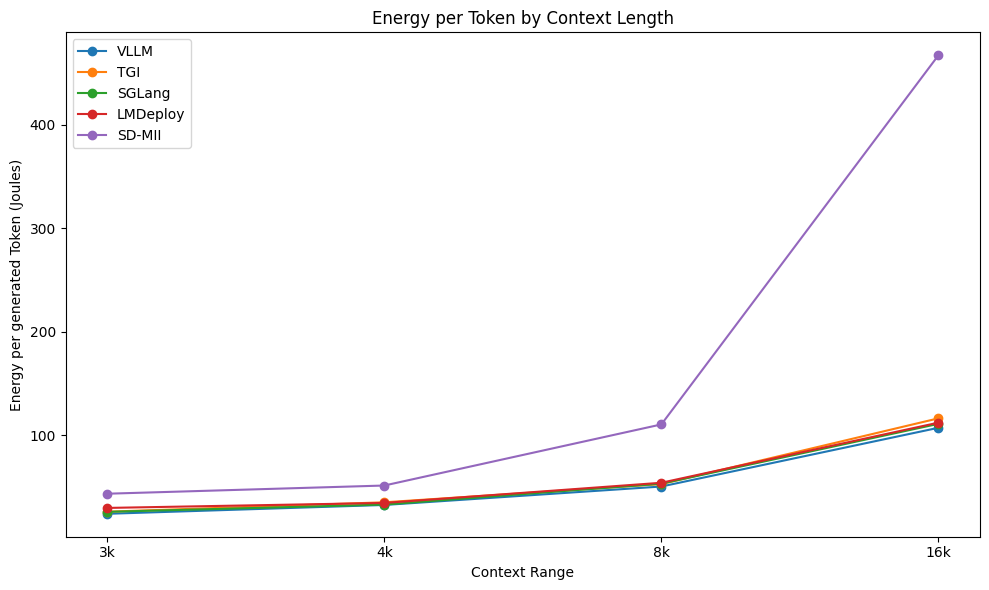

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure both agg_sg and agg_vllm have 'energy_sd' column (standard deviation)
# If not already done, compute it before this step

# Add backend labels
agg_sg["backend"] = "SGLang"
agg_vllm["backend"] = "VLLM"
agg_tgi["backend"] = "TGI"
agg_lmd["backend"] = "LMDeploy"
agg_mii["backend"] = "SD-MII"

# Combine data
combined_df = pd.concat([agg_sg, agg_vllm, agg_tgi, agg_lmd, agg_mii], ignore_index=True)
combined_df = combined_df.rename(columns={"energy_sd": "sd"})

plt.figure(figsize=(10, 6))
for backend, color in zip(["VLLM", "TGI", "SGLang", "LMDeploy", "SD-MII"], ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]):
    subset = combined_df[combined_df["backend"] == backend]
    lower = (subset["energy_per_token"] - subset["sd"]).clip(lower=0)
    upper = subset["energy_per_token"] + subset["sd"]

    plt.plot(subset["context_range"], subset["energy_per_token"], marker="o", label=backend, color=color)
#    plt.fill_between(
#        subset["context_range"],
#        lower,
#        upper,
#        alpha=0.3,
#        color=color
#    )

plt.title("Energy per Token by Context Length")
plt.xlabel("Context Range")
plt.ylabel("Energy per generated Token (Joules)")
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_196244/6882233.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipykernel_196244/6882233.py:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.barplot(


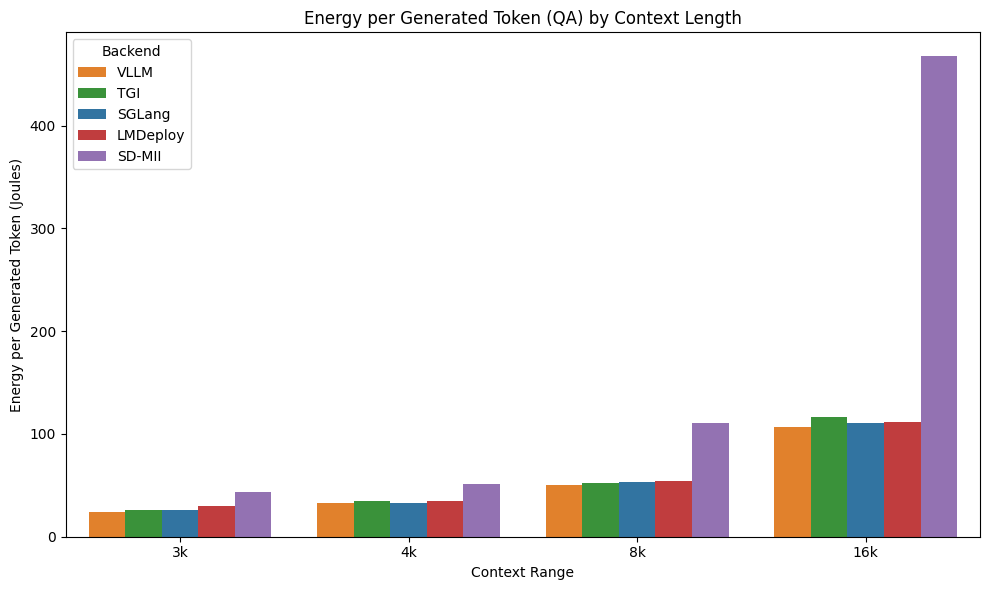

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure consistent ordering of backends
backend_order = [ "VLLM", "TGI", "SGLang", "LMDeploy", "SD-MII"]
context_order = ["3k", "4k", "8k", "16k"]
combined_df["backend"] = pd.Categorical(combined_df["backend"], categories=backend_order, ordered=True)
combined_df["context_range"] = pd.Categorical(combined_df["context_range"], categories=context_order, ordered=True)

plt.figure(figsize=(10, 6))

# Plot grouped bars with SD
sns.barplot(
    data=combined_df,
    x="context_range",
    y="energy_per_token",
    hue="backend",
    ci=None,
    capsize=0.15,
    errwidth=1.5,
    hue_order=backend_order,
    palette={
        "TGI": "#2ca02c",
        "VLLM": "#ff7f0e",
        "SGLang": "#1f77b4",
        "LMDeploy": "#d62728",
        "SD-MII": "#9467bd"
    }
)

# Add error bars manually for each bar in grouped layout
bar_width = 0.8 / len(backend_order)  # Divide bar width across N backends
backend_offsets = {
    name: -0.3 + i * bar_width for i, name in enumerate(backend_order)
}


plt.title("Energy per Generated Token (QA) by Context Length")
plt.xlabel("Context Range")
plt.ylabel("Energy per Generated Token (Joules)")
plt.legend(title="Backend")
plt.tight_layout()
plt.show()

In [16]:
def aggregate_f1_scores(df):
    """
    Aggregate F1 scores by context range, excluding '32k'.
    Returns a DataFrame with mean F1 scores for each context range.
    """
    custom_order = ["3k", "4k", "8k", "16k"]  # exclude "32k"
    
    agg = (
        df[df["context_range"] != "32k"]
        .groupby("context_range")["F1_score"]
        .agg(["mean"])
        .reindex(custom_order)
        .reset_index()
        .rename(columns={"mean": "F1_score"})
    )
    
    return agg

aggregate_f1_scores(df_vllm)

,context_range,F1_score
0,3k,0.378022
1,4k,0.426543
2,8k,0.302506
3,16k,0.348091


In [17]:
aggregate_f1_scores(df_sglang)

,context_range,F1_score
0,3k,0.374421
1,4k,0.434613
2,8k,0.303398
3,16k,0.348375


In [18]:
aggregate_f1_scores(df_tgi)

,context_range,F1_score
0,3k,0.376079
1,4k,0.436156
2,8k,0.317188
3,16k,0.358306


In [19]:
aggregate_f1_scores(df_lmdeploy)

,context_range,F1_score
0,3k,0.378400
1,4k,0.444433
2,8k,0.306778
3,16k,0.345642
